0. Install and import libraries


XLM-Roberta on multilingual text

- Training data + augmentation data
- Weighted loss = 25% Overall + (50% / 6 = 12.5%) for each of the remaining 6 labels
- Model parameter file: Multilingual_Bert_0.50_overall_loss.pth

### Using testing_set.csv and training_data.csv file for this task and both are stored in the same folder with this .ipynb file. In case you have different location , please update the path.

In [ ]:
#Attach your google drive if you are running this file using google colab.
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#In case you are running this notebook using google colab then uncomment the below lines otherwiese make sure it is installed in your system if running using VS code.

#!pip install transformers
#!pip install sentencepiece

In [ ]:
#Imporint required packages.
import pandas as pd
import numpy as np
import random
import json
import regex as re

import matplotlib.pyplot as plt
import os
import sentencepiece
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from transformers import AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import XLMRobertaConfig, XLMRobertaModel, XLMRobertaTokenizer

torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# from google.colab import drive
# drive.mount('/content/drive')
# LIBRARY_PATH = '/content/drive/MyDrive/Colab Notebooks/training_data.csv'

# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
#Reading csv file using pandas from gogole drive location
training_data = pd.read_csv('training_data.csv')
training_data = training_data.dropna() #Removing null rows from training data frame.
training_data

,Unnamed: 0,url1_lang,url2_lang,link1,link2,ia_link1,ia_link2,Geography,Entities,Time,Narrative,Overall,Style,Tone,id_1,id_2,text_1,text_2,title_1,title_2
3,3,en,en,https://gadgets.ndtv.com/apps/news/zomato-uber...,https://gadgets.ndtv.com/internet/news/indian-...,https://web.archive.org/web/gadgets.ndtv.com/a...,https://web.archive.org/web/gadgets.ndtv.com/i...,1.000000,2.333333,2.666667,1.666667,2.000000,1.666667,1.666667,1576314516,1576455088,Uber has sold its online food-ordering busines...,Rapid digitisation and growth in both online b...,Zomato Buys Uber's Food Delivery Business in I...,Indian Online Food Delivery Market to Hit $8 B...
5,5,en,en,https://jewishjournal.com/news/nation/309033/w...,https://jewishjournal.com/online/309000/jewish...,https://web.archive.org/web/jewishjournal.com/...,https://web.archive.org/web/jewishjournal.com/...,1.250000,1.750000,1.250000,1.750000,2.000000,1.000000,1.250000,1484189120,1484113136,The Simon Wiesenthal Center called on the Whit...,Jewish groups have expressed shock and horror ...,Wiesenthal Center Calls for FBI Task Force to ...,Jewish Groups React to Monsey Stabbings
6,6,en,en,https://www.financialexpress.com/market/commod...,https://www.financialexpress.com/india-news/de...,https://web.archive.org/web/www.financialexpre...,https://web.archive.org/web/www.financialexpre...,3.000000,4.000000,1.333333,4.000000,3.666667,1.333333,1.333333,1484034982,1483785560,The government on Wednesday slashed import dut...,Delhiites continued to remain in grip of cold ...,Big cut on import duty on crude and refined pa...,Delhi weather update: Delhiites shiver at 2.4 ...
7,7,en,en,https://www.opednews.com/articles/The-biggest-...,https://nypost.com/2019/12/31/the-lefts-consta...,https://web.archive.org/web/www.opednews.com/a...,https://web.archive.org/web/nypost.com/2019/12...,2.333333,3.666667,1.333333,3.666667,3.333333,1.333333,1.333333,1484188439,1484378177,From The Guardian\n\nFrom Boeing to Whole Food...,Police have arrested a 38-year-old black man f...,The biggest business con of 2019: fleecing wor...,The left’s constant victimhood olympics is a g...
8,8,en,en,https://www.amazon.com/dp/154173016X/?tag=slat...,https://www.amazon.com/dp/1610399579/?tag=slat...,https://web.archive.org/web/www.amazon.com/dp/...,https://web.archive.org/web/www.amazon.com/dp/...,1.000000,4.000000,4.000000,1.000000,4.000000,1.000000,1.000000,1484011751,1483920335,Review\n\nCrimeReads best nonfiction crime boo...,"Enter the characters you see below\n\nSorry, w...",The Compatriots: The Brutal and Chaotic Histor...,Amazon.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,2926,ar,ar,https://www.omandaily.om/?p=786245,https://www.masrawy.com/news/news_publicaffair...,https://web.archive.org/web/www.omandaily.om/?...,https://web.archive.org/web/www.masrawy.com/ne...,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1592085965,1567830952,الطيران العماني يواصل رحلات الشحن لتعزيز الأمن...,مسقط - أ ش أ\n\nقام الطيران العماني، الناقل ال...,الطيران العماني يواصل رحلات الشحن لتعزيز الأمن...,الطيران العماني يسيّر رحلات شحن إلى الهند لتوف...
2928,2928,ar,ar,https://www.albawabhnews.com/3962000,https://www.vetogate.com/3959908/%D8%B6%D8%A8%...,https://web.archive.org/web/www.albawabhnews.c...,https://web.archive.org/web/www.vetogate.com/3...,2.000000,3.000000,3.000000,2.000000,4.000000,1.000000,1.000000,1566447642,1582626838,تمكن رجال مباحث القاهرة تحت إشراف اللواء أشرف ...,ألقى رجال المباحث بمديرية أمن القاهرة برئاسة ا...,القبض على عنصر إجرامي تخصص في سرقة السيارات با...,ضبط ترزى لتصنيعه 1600 كمامة ورداء طبى بدون تصر...
2929,2929,ar,ar,https://www.masrawy.com/news/news_egypt/detail...,https://www.elwatannews.com/news/details/4728427,https://web.archive.org/web/www.masrawy.com/ne...,https://web.archive.org/web/www.elwatannews.co...,1.000000,2.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1644102363,1594269711,كتب- مصراوي:\n\nأكدت الشركة المتحدة للخدمات ال...,قال الإما

In [ ]:
#Function to merge columns and returning the transformed data frame.
def merge_clean_columns(df):
    """
    Merge multiple columns into one and clean text
    """
    df['merge1'] = df['text_1'].astype(str) + ', ' \
        + df['title_1'].astype(str)

    df['merge2'] = df['text_2'].astype(str) + ', ' \
        + df['title_2'].astype(str)

    return df





In [ ]:
processed_data = merge_clean_columns(training_data) #Calling merge_clean_columns function.
# split into train and development
train, dev = train_test_split(processed_data, test_size=0.1, random_state = 42) #spliting processed data frame in to train and dev using train_test_split method from sklearn.model_selection

## 2. Model on data text

In [ ]:

# set parameters
max_len = 512
batch_size = 5
lr = 5e-6
weight_decay = 1e-4
num_epochs = 8


In [ ]:
#Defining function get_data_loader for modeling
def get_data_loader(data, batch_size_flg = True):
  tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
  input_ids, attention_masks, labels = [], [], []
  for idx, row in data.iterrows():
      text1, text2 = row['merge1'], row['merge2']
      encode_dict = tokenizer(text1,text2,
                                  max_length=max_len,
                                  padding='max_length',
                                  truncation=True,
                                  add_special_tokens=True
                                  )

      input_ids.append(encode_dict['input_ids'])
      attention_masks.append(encode_dict['attention_mask'])
      # model is used to predict all labels?? -> should we convert to only 1 label
      labels.append([float(x) for x in [row['Geography'],row['Entities'],row['Time'],row['Narrative'],row['Overall'],row['Style'],row['Tone']]])

  input_ids = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)
  labels = torch.tensor(labels)

  data = TensorDataset(input_ids, attention_masks, labels)
  if(batch_size_flg):
      data_loader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
  else:
      data_loader = DataLoader(data)
  return data_loader


In [ ]:
train_data_loader = get_data_loader(train)
eval_data_loader = get_data_loader(dev, False)

In [ ]:
#Defining class Custom_BERT with construction and one formward method.
class Custom_BERT(nn.Module):
    def __init__(self, model, hidden_size):
        super(Custom_BERT, self).__init__()
        self.reg_model = model
        self.fc1 = nn.Linear(hidden_size, 512)
        # self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)
        self.fc4 = nn.Linear(100,7) # currently processes the 7 labels that we have defined for 7 output types
        self.activation1 = nn.GELU()
        self.activation2 = nn.GELU()
        self.activation3 = nn.GELU()

    def forward(self, input_ids, attention_masks):
        output1 = self.reg_model(input_ids, attention_masks)[1]
        # output2 =
        # x = self.dropout(x)
        # logits1= s
        logits1= self.fc3(self.activation2(self.fc2(self.activation1(self.fc1(output1)))))
        logits1 = self.fc4(logits1)

        return logits1

In [ ]:
import numpy as np
from scipy.stats import pearsonr
#Functing to calculate pearson values.
def calculate_pearson_per_aspect(predictions, labels):
    """
    Calculates Pearson correlation for each aspect (output dimension).

    Args:
    - predictions: numpy array of shape (N, 7) containing model predictions.
    - labels: numpy array of shape (N, 7) containing ground truth scores.

    Returns:
    - correlations: List of Pearson correlation coefficients for each aspect.
    """
    correlations = []
    predictions = np.array(predictions)
    labels = np.array(labels)
    for i in range(predictions.shape[1]):  # Loop through each of the 7 output scores
        r, _ = pearsonr(predictions[:, i], labels[:, i])
        correlations.append(r)
    return correlations






In [ ]:
train_losses=[]
val_losses =[]
pearson_scores = []
#Defining function to evaluate.
def evaluate(model, data_loader,criterion):
  model.eval()
  overall_pred, overall_true = [], []
  with torch.no_grad():
    val_loss_sum=0
    for idx, (ids, att_msks, y) in enumerate(data_loader):
      ids, att_msks, y = ids.to(device), att_msks.to(device), y.to(device)
      y_pred = model(ids, att_msks)
      loss = criterion(torch.squeeze(y_pred),torch.squeeze(y))
      val_loss_sum += loss.item()

      y_pred, y = torch.squeeze(y_pred).cpu().numpy().tolist(), torch.squeeze(y).cpu().numpy().tolist()
      overall_pred.append(y_pred)
      overall_true.append(y)
  val_losses.append(val_loss_sum/len(data_loader))
  return overall_pred, overall_true



#Defining function to train the data.
def train(model, model_path, train_data_loader, eval_data_loader, optimizer, loss_weights, epochs):
  model.train()
  criterion = nn.MSELoss()
  best_pearson = 0
  for i in range(epochs):
    train_loss_sum = 0
    for idx, (ids, att_msks, y) in enumerate(train_data_loader):
      print(idx)
      ids, att_msks, y = ids.to(device), att_msks.to(device), y.to(device)
      optimizer.zero_grad()
      y_pred = model(ids, att_msks)
      y_pred, y = torch.squeeze(y_pred), torch.squeeze(y) ## required because y is a vector
      # loss = weighted_loss(y_pred, y, criterion, loss_weights)
      print(y_pred)
      loss = criterion(y_pred,y)
      loss.backward()
      optimizer.step()
      train_loss_sum += loss.item()

    train_losses.append(train_loss_sum/len(train_data_loader))
    print(f"Loss at epoch {i}: {train_loss_sum:.4f}")

    ## Determine best epoch model using correlation coefficient for Overall in dev data
    eval_pred_overall, eval_true_overall = evaluate(model, eval_data_loader,criterion)

    pearson_correlations = calculate_pearson_per_aspect(eval_pred_overall, eval_true_overall)
    for i, r in enumerate(pearson_correlations):
        print(f"Pearson correlation for aspect {i+1}: {r:.4f}")

    # Optionally, calculate the mean Pearson correlation
    curr_pearson = np.mean(pearson_correlations)
    print(f"Mean Pearson correlation: {curr_pearson:.4f}")
    pearson_scores.append(curr_pearson)


    # curr_pearson = np.corrcoef(eval_pred_overall, eval_true_overall)[0][1]
    # print(curr_pearson)
    if curr_pearson > best_pearson:
      best_pearson = curr_pearson
      torch.save(model.state_dict(), model_path)



### Training model

In [ ]:
torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")



In [ ]:
from transformers import BertModel, BertConfig, BertTokenizer

# Load pre-trained multilingual BERT model and configuration
pre_trained_model = BertModel.from_pretrained("bert-base-multilingual-cased")
config = BertConfig.from_pretrained("bert-base-multilingual-cased")

# Get the hidden size from the model configuration
hidden_size = config.hidden_size

# Define loss weights (assume 7 output classes)
overall_weight = 0.25
loss_weights = [overall_weight if i == 4 else (1-overall_weight)/6 for i in range(7)]

# Initialize custom model
model = Custom_BERT(pre_trained_model, hidden_size)
model.to(device)

# Path  to save the trained model
model_path = "BERT_Multilingual_0.25_overall_loss.pth"


In [ ]:
optimizer = AdamW(model.parameters(), lr=lr, weight_decay = weight_decay)
train(model, model_path, train_data_loader, eval_data_loader, optimizer, loss_weights, num_epochs)





/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Streaming output truncated to the last 5000 lines.
        [1.0389, 1.5559, 0.9239, 1.5406, 1.4873, 1.0168, 1.0229],
        [1.5454, 2.2096, 1.2543, 2.1931, 2.1464, 1.3842, 1.3854]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
142
tensor([[2.8955, 3.8429, 2.0774, 3.8524, 3.8337, 2.2286, 2.3074],
        [3.0595, 4.0384, 2.1746, 4.0449, 4.0127, 2.3499, 2.4247],
        [1.9368, 2.7028, 1.4992, 2.6889, 2.6508, 1.6421, 1.6588],
        [2.0771, 2.8739, 1.5863, 2.8643, 2.8268, 1.7352, 1.7553],
        [3.0477, 4.0192, 2.1669, 4.0292, 3.9995, 2.3320, 2.4149]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
143
tensor([[1.3445, 1.9563, 1.1263, 1.9371, 1.8882, 1.2437, 1.2440],
        [1.1188, 1.6625, 0.9792, 1.6464, 1.5941, 1.0793, 1.0817],
        [3.0548, 4.0349, 2.1710, 4.0371, 4.0029, 2.3476, 2.4234],
        [1.1805, 1.7433, 1.0196, 1.7256, 1.6745, 1.1244, 1.1255],
        [2.6472, 3.5585, 1.9302, 3.5612, 3.5383, 2.0804, 2.1419]],
       device='cuda:0', grad_fn=<SqueezeBa

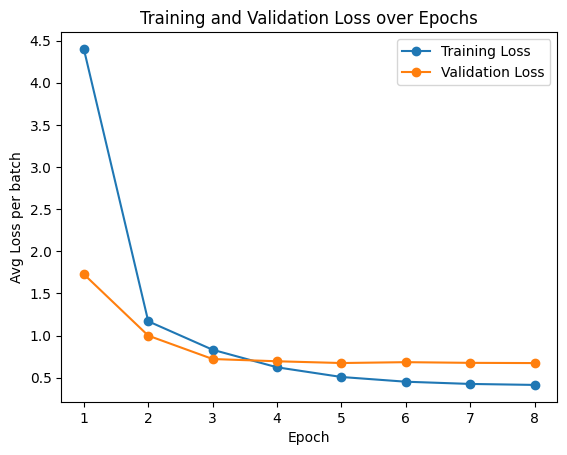

In [ ]:

import matplotlib.pyplot as plt

# Plot the loss curves
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')

plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Avg Loss per batch')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

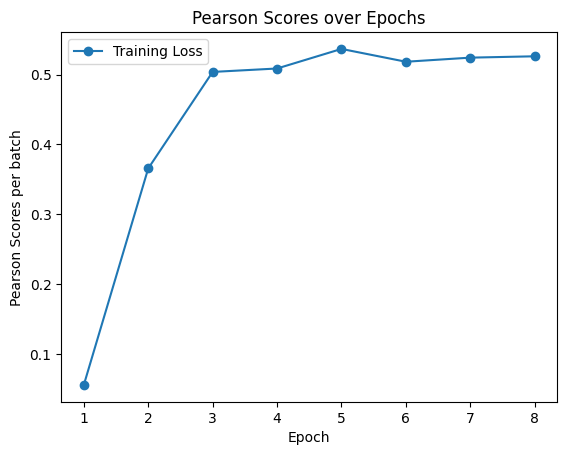

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.plot(range(1, num_epochs + 1), pearson_scores, marker='o', label='Training Loss')

# plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Pearson Scores per batch')
plt.title('Pearson Scores over Epochs')
plt.legend()
plt.show()

## 4. Evaluation on test data

In [ ]:
#Defining function to predit the model
def predict(model, data_loader):
  model.eval()
  overall_pred, overall_true = [], []
  with torch.no_grad():
    val_loss_sum=0
    for idx, (ids, att_msks, y) in enumerate(data_loader):
      ids, att_msks, y = ids.to(device), att_msks.to(device), y.to(device)
      y_pred = model(ids, att_msks)


      y_pred, y = torch.squeeze(y_pred).cpu().numpy().tolist(), torch.squeeze(y).cpu().numpy().tolist()
      overall_pred.append(y_pred)
      overall_true.append(y)

  return overall_pred, overall_true


In [ ]:
test_data = pd.read_csv('testing_set.csv')
test_data = test_data[test_data['lang1']==test_data['lang2']]
test_data = test_data.rename(columns={'text_1': 'merge1', 'text_2': 'merge2'})
test_data_loader = get_data_loader(test_data,False)

model.load_state_dict(torch.load("BERT_Multilingual_0.25_overall_loss.pth"), strict=False)
model.to(device)
test_pred_overall, test_true_overall = predict(model, test_data_loader)
print(test_pred_overall)


<ipython-input-36-3df337dbeff9>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("BERT_Multilingual_0.25_overall_loss.pth"), strict=False)


[[1.361519694328308, 1.9247442483901978, 1.1100759506225586, 1.9309498071670532, 1.8876211643218994, 1.2195284366607666, 1.2453298568725586], [1.2718610763549805, 1.8117040395736694, 1.0497748851776123, 1.8169597387313843, 1.7744255065917969, 1.1505122184753418, 1.1824922561645508], [1.7983062267303467, 2.471595048904419, 1.3867868185043335, 2.490954875946045, 2.450662136077881, 1.526197075843811, 1.5605626106262207], [1.3124758005142212, 1.8632841110229492, 1.0769702196121216, 1.8688058853149414, 1.8244779109954834, 1.1788688898086548, 1.2112394571304321], [1.4598785638809204, 2.050065517425537, 1.1719162464141846, 2.057950258255005, 2.0160953998565674, 1.2876262664794922, 1.3176733255386353], [1.6732217073440552, 2.3167724609375, 1.3083795309066772, 2.331407308578491, 2.290336847305298, 1.436367392539978, 1.4714337587356567], [2.166170120239258, 2.9190115928649902, 1.614565134048462, 2.951693058013916, 2.9148216247558594, 1.7684720754623413, 1.8173811435699463], [2.6977972984313965, 

In [ ]:
pearson_correlations = calculate_pearson_per_aspect(test_pred_overall, test_true_overall)
for i, r in enumerate(pearson_correlations):
        print(f"Pearson correlation for aspect {i+1}: {r:.4f}")

curr_pearson = np.mean(pearson_correlations)
print(f"Mean Pearson correlation for test dataset: {curr_pearson:.4f}")

Pearson correlation for aspect 1: 0.5494
Pearson correlation for aspect 2: 0.7449
Pearson correlation for aspect 3: 0.2245
Pearson correlation for aspect 4: 0.7181
Pearson correlation for aspect 5: 0.7489
Pearson correlation for aspect 6: 0.3203
Pearson correlation for aspect 7: 0.3828
Mean Pearson correlation for test dataset: 0.5270


In [ ]:
test_pred_overall

[[1.361519694328308,
  1.9247442483901978,
  1.1100759506225586,
  1.9309498071670532,
  1.8876211643218994,
  1.2195284366607666,
  1.2453298568725586],
 [1.2718610763549805,
  1.8117040395736694,
  1.0497748851776123,
  1.8169597387313843,
  1.7744255065917969,
  1.1505122184753418,
  1.1824922561645508],
 [1.7983062267303467,
  2.471595048904419,
  1.3867868185043335,
  2.490954875946045,
  2.450662136077881,
  1.526197075843811,
  1.5605626106262207],
 [1.3124758005142212,
  1.8632841110229492,
  1.0769702196121216,
  1.8688058853149414,
  1.8244779109954834,
  1.1788688898086548,
  1.2112394571304321],
 [1.4598785638809204,
  2.050065517425537,
  1.1719162464141846,
  2.057950258255005,
  2.0160953998565674,
  1.2876262664794922,
  1.3176733255386353],
 [1.6732217073440552,
  2.3167724609375,
  1.3083795309066772,
  2.331407308578491,
  2.290336847305298,
  1.436367392539978,
  1.4714337587356567],
 [2.166170120239258,
  2.9190115928649902,
  1.614565134048462,
  2.951693058013916